In [1]:
%load_ext autoreload
%autoreload 2
    
from d3pm_runner import *

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

In [2]:
N = 2  # number of classes for discretized state per pixel
d3pm = D3PM(DummyX0Model(1, N), 1000, num_classes=N, hybrid_loss_coeff=0.0).cuda()
print(f"Total Param Count: {sum([p.numel() for p in d3pm.x0_model.parameters()])}")
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Pad(2),
        ]
    ),
)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=32)


Total Param Count: 63278080


/vast/aa11803/miniconda3/envs/diffusion/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


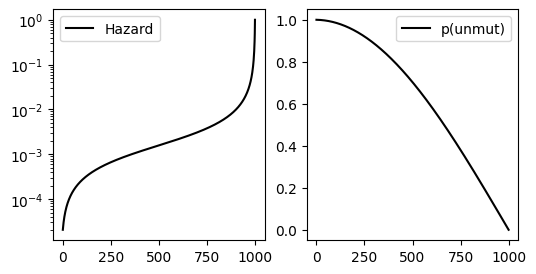

In [3]:
fig, ax = plt.subplots(1, 2, figsize=[6, 3])
ax[0].semilogy(d3pm.beta_t, label="Hazard", color='black')
ax[0].legend()

steps = torch.arange(d3pm.n_T + 1, dtype=torch.float64) / d3pm.n_T
alpha_bar = torch.cos((steps + 0.008) / 1.008 * torch.pi / 2)
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

In [54]:
optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-3)
d3pm.train()

n_epoch = 14
device = "cuda"

global_step = 0
for i in range(n_epoch):

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, cond in pbar:
        optim.zero_grad()
        x = x.to(device)
        cond = cond.to(device)

        # discritize x to N bins
        x = (x * (N - 1)).round().long().clamp(0, N - 1)
        loss, info = d3pm(x, cond)

        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(d3pm.x0_model.parameters(), 0.1)

        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in d3pm.x0_model.parameters()])

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(
            f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}"
        )
        optim.step()
        global_step += 1

        if global_step % 300 == 1:
            d3pm.eval()

            with torch.no_grad():
                cond = torch.arange(0, 4).cuda() % 10
                init_noise = torch.randint(0, N, (4, 1, 32, 32)).cuda()

                images = d3pm.sample_with_image_sequence(
                    init_noise, cond, stride=40
                )
                # image sequences to gif
                gif = []
                for image in images:
                    x_as_image = make_grid(image.float() / (N - 1), nrow=2)
                    img = x_as_image.permute(1, 2, 0).cpu().numpy()
                    img = (img * 255).astype(np.uint8)
                    gif.append(Image.fromarray(img))

                gif[0].save(
                    f"contents/sample_{global_step}.gif",
                    save_all=True,
                    append_images=gif[1:],
                    duration=100,
                    loop=0,
                )

                last_img = gif[-1]
                last_img.save(f"contents/sample_{global_step}_last.png")

            d3pm.train()

loss: 43.1459, norm: 15.4711, param_norm: 1212.2456, vb_loss: 43.1459, ce_loss: 
0it [00:00, ?it/s]
1it [00:00,  8.17it/s]
3it [00:00, 12.81it/s]
13it [00:00, 46.53it/s]
23it [00:00, 64.32it/s]
33it [00:00, 74.76it/s]
43it [00:00, 81.24it/s]
53it [00:00, 85.58it/s]
63it [00:00, 88.51it/s]
73it [00:00, 90.50it/s]
83it [00:01, 91.73it/s]
93it [00:01, 92.65it/s]
103it [00:01, 91.03it/s]
113it [00:01, 92.10it/s]
123it [00:01, 92.86it/s]
133it [00:01, 93.47it/s]
143it [00:01, 93.86it/s]
153it [00:01, 94.21it/s]
163it [00:01, 94.05it/s]
173it [00:02, 93.42it/s]
183it [00:02, 93.92it/s]
193it [00:02, 94.25it/s]
203it [00:02, 94.08it/s]
213it [00:02, 94.23it/s]
223it [00:02, 94.44it/s]
233it [00:02, 94.27it/s]
243it [00:02, 94.36it/s]
253it [00:02, 94.57it/s]
263it [00:03, 94.45it/s]
273it [00:03, 94.51it/s]
283it [00:03, 94.58it/s]
293it [00:03, 94.59it/s]
303it [00:03, 94.64it/s]
313it [00:03, 94.64it/s]
323it [00:03, 94.54it/s]
333it [00:03, 94.47it/s]
343it [00:03, 94.56it/s]
353it [00:03,

In [55]:
torch.save(d3pm.state_dict(), 'models/d3pm_cifar10_aug10')

In [57]:
import gc
torch.cuda.empty_cache()
gc.collect()

n_samples = 1500

cond = torch.zeros(n_samples).cuda().to(torch.int64)
init_noise = torch.randint(0, N, (n_samples, 1, 32, 32)).cuda()

images = d3pm.sample_with_image_sequence(
    init_noise, cond, stride=1
)
images = torch.cat(images, 1)
images = torch.cat([init_noise, images], 1)
diffs = (images[:, 1:, :, :] != images[:, :-1, :, :]).reshape(n_samples, 999, -1)

999it [04:44,  3.51it/s]


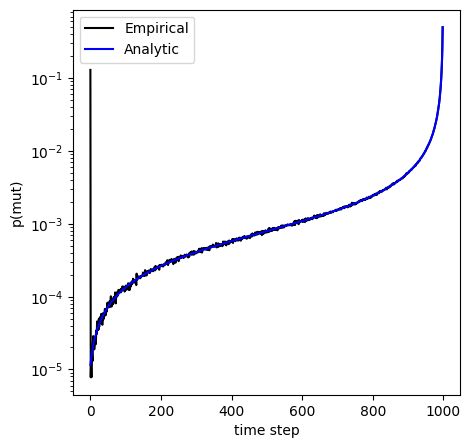

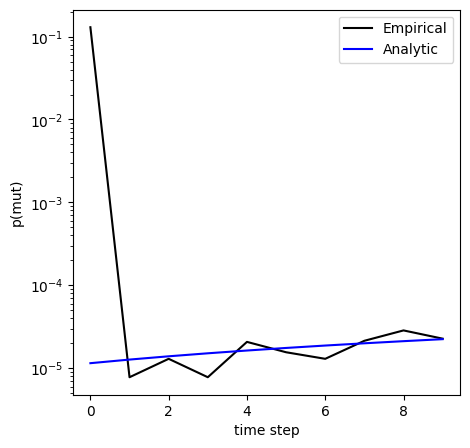

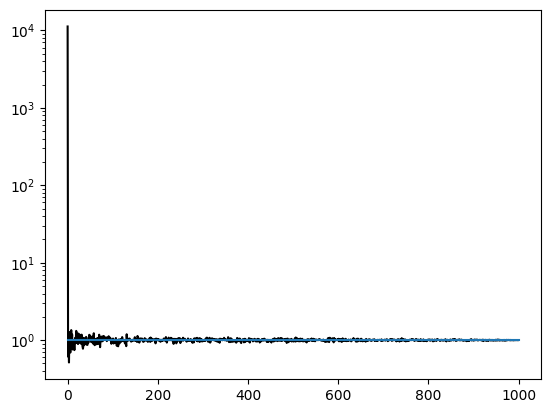

In [58]:
r1 = diffs.cpu().numpy().mean(0).mean(-1)[::-1]
r2 = d3pm.beta_t[1:].cpu().numpy() / 2
plt.figure(figsize=[5, 5])
plt.semilogy(r1, label="Empirical", color='black')
plt.semilogy(r2, label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
plt.savefig("figures/schedule_comparison.png")

plt.figure(figsize=[5, 5])
plt.semilogy(r1[:10], label="Empirical", color='black')
plt.semilogy(r2[:10], label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
plt.savefig("figures/schedule_comparison_zoom.png")

plt.figure()
plt.semilogy(r1/r2, color='black')
plt.plot([0, 1000], np.ones(2))

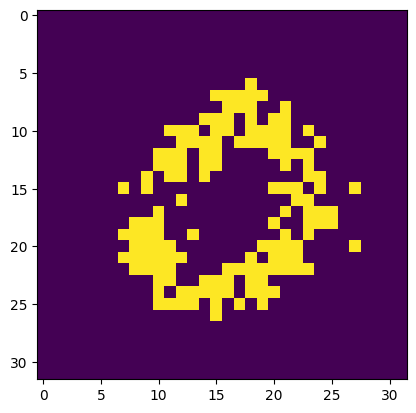

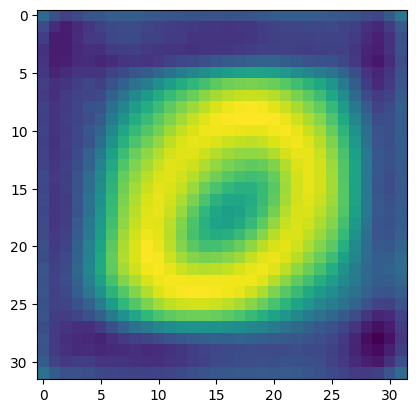

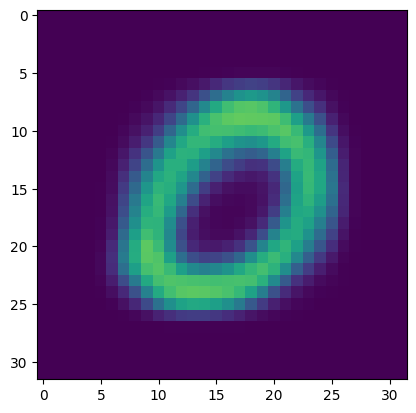

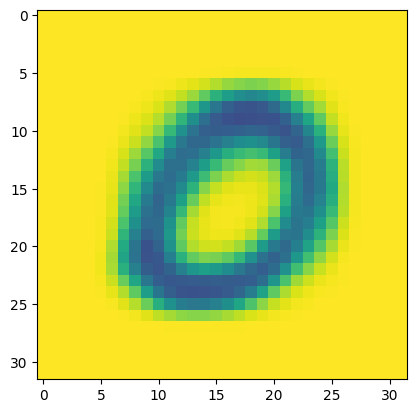

In [38]:
with torch.no_grad():
    t = 1#d3pm.n_T-1
    t = torch.tensor([t], device=init_noise.device)
    x = images[[1]][:, [-2]]
    preds = d3pm.x0_model(x, t, cond[[0]])
    ps = d3pm.q_posterior_logits(preds, x, t)
    
    preds = preds.squeeze()
    preds = preds.cpu().numpy()[:, :, -1]
    plt.imshow(x.squeeze().cpu().numpy())
    plt.figure()
    plt.imshow(preds)#, vmin=0, vmax=1)
    plt.figure()
    ps = ps.squeeze()
    ps = torch.softmax(ps, dim=-1).cpu().numpy()
    plt.imshow(ps[:, :, -1], vmin=0, vmax=1)
    plt.figure()
    plt.imshow(ps[:, :, 0], vmin=0, vmax=1)

In [47]:
# r1 = d3pm.beta_t[100:-1]
# r2 = rates[100:]
kl = r1 * (np.log(r1) - np.log(r2)) + (1-r1) * (np.log(1-r1) - np.log(1-r2))
print(kl.sum())

1.117064540897708


Text(0.5, 0, 'step')

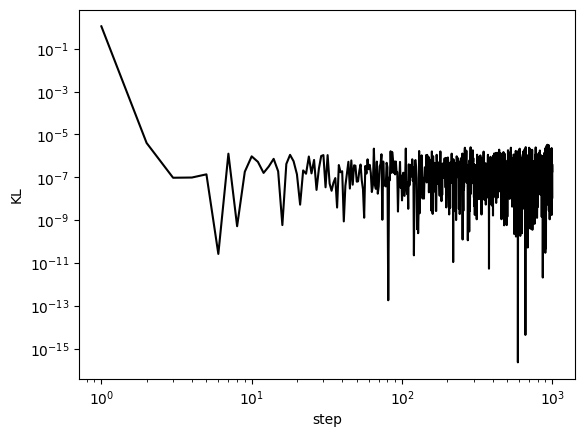

In [59]:
plt.loglog(np.arange(1, 1000), kl, color='black')
plt.ylabel("KL")
plt.xlabel("step")